In [150]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from EMD_lib import cubic_spline_3pts, EMD

In [323]:
def get_data(df, mode='original', emd=False, dimension='one', window_size=0):
    delta_seconds = df.event_timestamp.diff() / np.timedelta64(1, 's')
    delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
    delta_seconds = delta_seconds[1:]

    AP = df['Total_AP_energy_max']

    a = []
    for j, i in enumerate(df['Total_AP_energy_max']):
        try:
            i = float(i)
        except ValueError:
            a.append(j)
    for i in a:
        AP[i] = AP[i - 1]

    AP = np.diff(np.array(AP, dtype = float)) * 1000
    X = AP / delta_seconds
    df['total_AP'] = X
    if emd:
        ind = np.where(df.event_timestamp.apply(datetime.time) > datetime.strptime('23:58:00', '%H:%M:%S').time())[0]
        #print(ind)
        prev = 0
        #df_help = pd.DataFrame(columns=df.columns)
        k = 0
        for i in ind[1:]:
            print(i)
            #print(df.loc[prev:i])
            st = np.where(df['total_AP'][prev:i] > 1)[0][0] + prev
            end = np.where(df['total_AP'].loc[prev:i] > 1)[0][len(np.where(df['total_AP'].loc[prev:i] > 1)[0]) - 1] + prev
            emd = EMD()
            emd.emd(np.array(df['total_AP'][st:end]))
            imfs, res = emd.get_imfs_and_residue()
            print(st, end, k)
            #if k == 11:
                #return df['total_AP'][st:end]
            try:
                df['total_AP'][st:end] = imfs[2] + df['total_AP'][st:end].mean()
            except IndexError:
                try:
                    df['total_AP'][st:end] = imfs[1] + df['total_AP'][st:end].mean()
                except IndexError:
                    df['total_AP'][st:end] = imfs[0] + df['total_AP'][st:end].mean()
            #df_help = pd.concat((df_help, df.loc[st:end]), axis=0)
            prev = i
            
            k += 1

    if mode == 'original':   
        if dimension == 'one':
            return np.array(df['total_AP'])
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            X = np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']])
            return X
    elif mode == 'only_days':
        df = df[(df.event_timestamp.apply(datetime.time) < datetime.strptime('19:10:00', '%H:%M:%S').time()) & \
             (df.event_timestamp.apply(datetime.time) > datetime.strptime('6:40:00', '%H:%M:%S').time())].reset_index(drop=True)
        if dimension == 'one':
            return np.array(df['total_AP'])
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            X = np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']])
            return X
    elif mode == 'windows':
        ind = np.where(df.event_timestamp.apply(datetime.time) > datetime.strptime('23:58:00', '%H:%M:%S').time())[0]
        ans = []
        prev = 0
        if dimension == 'one':
            for i in ind:
                ans.append(np.array(df['total_AP'].loc[prev:i]))
                prev = i
            return np.array(ans)
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            for i in ind:
                ans.append(np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']][prev:i]))
                prev = i
            return np.array(ans)
                
    else:
        print('INCORRECT MODE')
        return None
    

In [75]:
'''
!!!!!!!!!!!!!!!!!!!!!!!!! мб EMD нужно делать окнами !!!!!!!!!!!!!!!!!!!!!!!!!!!!
curr = S[start[i]: end[i]]
  emd = EMD()
  emd.emd(curr)
  imfs, res = emd.get_imfs_and_residue()
  S[start[i]: end[i]] = imfs[2] + curr.mean()
'''

'''
original +
original emd +
original multi +
original multi emd +

----- правки ----
only_days +
only_days emd
only_days multi + 
only_days multi emd +

windows +
windows emd
windows multi +
windows multi emd
'''

'\noriginal +\noriginal emd\noriginal multi +\noriginal multi emd\n\nonly_days +\nonly_days emd\nonly_days multi + \nonly_days multi emd\n\nwindows +\nwindows emd\nwindows multi +\nwindows multi emd\n'

In [48]:
elec = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/ds_electricity.csv')

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (9,10,11,12,13,16,24,25,26,27,28,31,39,40,41,42,43,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [282]:
anom_0 = elec[elec.io_id == '5e03a7a2832a17ee33585ea4'].reset_index(drop=True)
anom_0.event_timestamp = pd.to_datetime(anom_0.event_timestamp, unit='s')

In [336]:
df = anom_0.loc[532778 - 730 * 3:532778 + 720 * 3].reset_index(drop=True) 
df = get_data(df, mode='windows', emd=True, dimension='one', window_size=720)

749
195 604 0
1469
916 1363 1
2189
1632 2044 2
2909
2360 2763 3
3629
3072 3486 4
4349
3824 4203 5


<ipython-input-323-62f69f997ea4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_AP'][st:end] = imfs[2] + df['total_AP'][st:end].mean()
<ipython-input-323-62f69f997ea4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_AP'][st:end] = imfs[2] + df['total_AP'][st:end].mean()
<ipython-input-323-62f69f997ea4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_AP'][st:end] = imfs[2] + df['total_AP'][st:end].me

In [334]:
df

array([array([[           nan, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.66666684e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.74999996e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.66666672e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.66666660e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.91666668e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.83333332e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.66666672e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.74999996e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.66666660e-03, 2.30000000e+01, 1.60000000e+01, 6.00000000e+00,
        1.00000000e+00],
       [2.75000008e-03,

ValueError: setting an array element with a sequence.

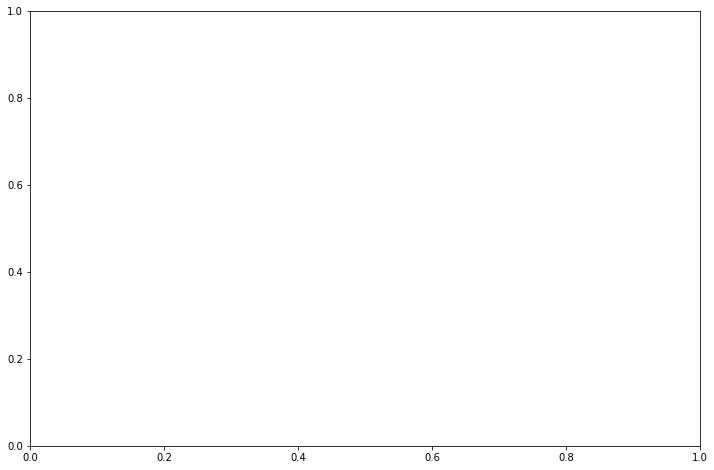

In [331]:
plt.figure(figsize=(12,8))
df_help = df
plt.plot(np.arange(len(df_help)),df_help)

ConversionError: Failed to convert value(s) to axis units: array(['5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4',
       '5e03a7a2832a17ee33585ea4', '5e03a7a2832a17ee33585ea4'],
      dtype=object)

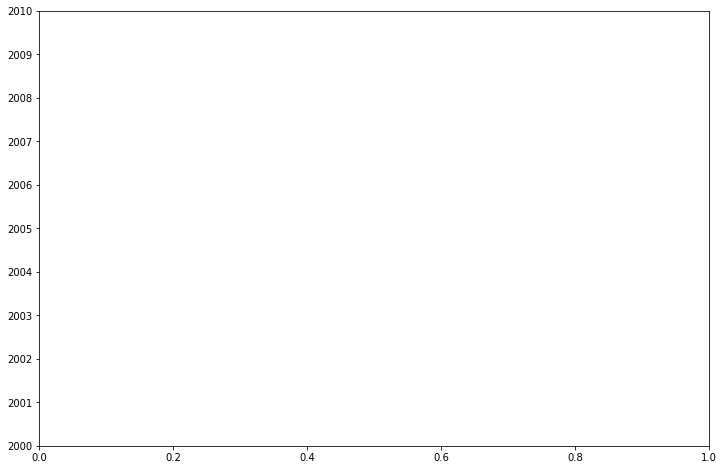

In [284]:
plt.figure(figsize=(12,8))
df_help = df[][:1000]
plt.plot(np.arange(len(df_help)),df_help)

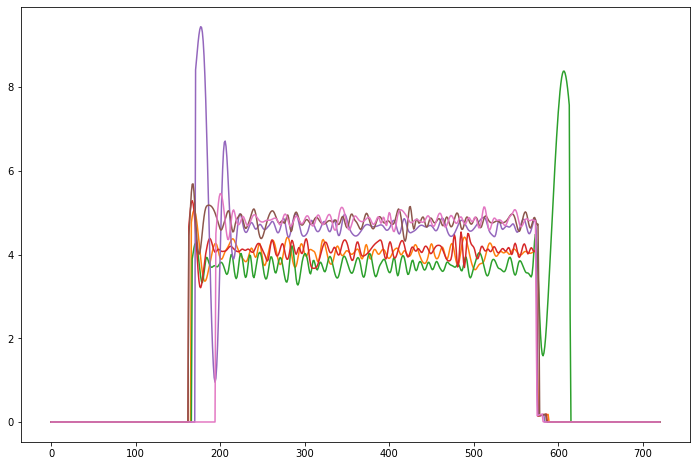

In [337]:
plt.figure(figsize=(12,8))
for i in df:
    plt.plot(np.arange(len(i)), i)